In [1]:
import pandas as pd

ames_housing = pd.read_csv("house_prices.csv", na_values="?")
# dropando a coluna "Id" que não tem poder nenhum preditivo
ames_housing = ames_housing.drop(columns="Id")
target_name = "SalePrice"
data, target = ames_housing.drop(columns=target_name), ames_housing[target_name]

Como podemos ver a variável target é numérica, portanto esse problema é um problema de regressão, iremos converter para um problema de classificação binária através da seguinte condição imposta:
* expensive(cara) para sale price --> $\gt 200,000$ USD.
* no expensive para sale price -->  $\le 200,000$ USD.

In [2]:
target = (target > 200_000).astype(int)
target

0       1
1       0
2       1
3       0
4       1
       ..
1455    0
1456    1
1457    1
1458    0
1459    0
Name: SalePrice, Length: 1460, dtype: int64

In [3]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [5]:
numerical_columns = data.select_dtypes(exclude=['object']).columns.to_list()
numerical_columns

['MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold']

In [6]:
print(f"O total de features numéricas é: {len(numerical_columns)}")

O total de features numéricas é: 36


## Criando um modelo preditivo com apenas as features numéricas
***

In [7]:
X = data[numerical_columns]
y = target

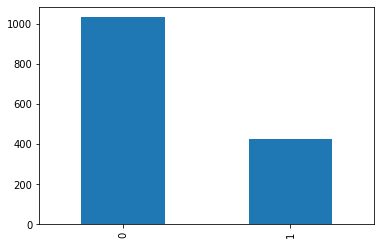

In [8]:
_ = target.value_counts().plot.bar()

In [9]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
set_config(display='diagram')

In [10]:
numerical_preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

In [11]:
logistic_model = make_pipeline(
    numerical_preprocessor,
    LogisticRegression(max_iter=500)
)
logistic_model

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('simpleimputer',
                                  SimpleImputer(strategy='median')),
                                 ('standardscaler', StandardScaler())])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [12]:
from sklearn.model_selection import cross_validate

In [13]:
%%time
cv_results = cross_validate(
    logistic_model, 
    X, y,
    cv = 5
)
scores = cv_results['test_score']
print(f"A média da acurácia no cross-validation é: {scores.mean():.3f} +/- {scores.std():.3f}")

A média da acurácia no cross-validation é: 0.921 +/- 0.014
CPU times: user 528 ms, sys: 718 ms, total: 1.25 s
Wall time: 371 ms


### Usando um pipeline que processa features numéricas e categóricas

In [14]:
categorical_columns = data.select_dtypes(include=['object']).columns
categorical_columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
categorical_preprocessor = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OneHotEncoder(handle_unknown='ignore')
)

numerical_preprocessor = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessor = ColumnTransformer(transformers =[
    ("num_preprocessor", numerical_preprocessor, numerical_columns),
    ("cat_preprocessor", categorical_preprocessor, categorical_columns)
])

In [16]:
model = make_pipeline(
    preprocessor,
    LogisticRegression(max_iter=500)
)
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num_preprocessor',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['MSSubClass', 'LotFrontage',
                                                   'LotArea', 'OverallQual',
                                                   'OverallCond', 'YearBuilt',
                                                   'YearRemodAdd', 'MasVnrArea',
                                                   'BsmtFinSF1', 'BsmtFinSF2',
                                                   'BsmtUnfSF', 'TotalBsmtSF...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('logisticregression', LogisticRegression(max_iter=500))])

In [17]:
model.named_steps

{'columntransformer': ColumnTransformer(transformers=[('num_preprocessor',
                                  Pipeline(steps=[('simpleimputer',
                                                   SimpleImputer(strategy='median')),
                                                  ('standardscaler',
                                                   StandardScaler())]),
                                  ['MSSubClass', 'LotFrontage', 'LotArea',
                                   'OverallQual', 'OverallCond', 'YearBuilt',
                                   'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
                                   'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
                                   '1stFlrSF', '2ndFlrSF', 'LowQualFinSF...
        'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
        'Func

In [18]:
%%time
cv_results = cross_validate(
    model,
    data, target,
    cv = 5
)
scores = cv_results['test_score']
print(f"A média da acurácia no cross-validation é: {scores.mean():.3f} +/- {scores.std():.3f}")

A média da acurácia no cross-validation é: 0.924 +/- 0.010
CPU times: user 1.11 s, sys: 0 ns, total: 1.11 s
Wall time: 1.11 s


In [19]:
from sklearn.metrics import accuracy_score, classification_report
model.fit(data, target)
target_predicted = model.predict(data)
accuracy_score(target, target_predicted)

0.9712328767123287

# Wrap-up quiz 4
***

Dado o conjunto de dados abaixo, responda algumas questões ao problema de predição da variável "**target = SalePrice**"

In [20]:
ames_housing = pd.read_csv("house_prices.csv", na_values="?")
target_name = "SalePrice"
data = ames_housing.drop(columns=target_name)
target = ames_housing[target_name]

In [21]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

data_numerical = data[numerical_features]

Comece ajustando um modelo de regressão linear (sklearn.linear_model.LinearRegression). Depois use uma validação cruzada de 10-fold e para o argumento return_estimator =True no objeto, sklearn.model_selection.cross_validate para acessar todos os estimadores ajustados em cada um dos folds. Não esqueça de padronizar os dados antes de passa-los ao regressor. Como também há alguns dados faltantes, é preciso imputar esses dados antes de alimenta-los ao regressor, para isso vc pode usar sklearn.impute.SimpleImputer com parâmetros default para imputar os dados faltantes. Então crie um modelo que terá um pipeline com a forma: 
* o padronizador-->imputer-->linear regression.

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import (
    KFold,
    cross_validate)
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn import set_config
set_config(display='diagram')

In [23]:
model = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='mean'),
    LinearRegression(n_jobs=-1)
)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [24]:
display("Os steps do pipeline:")
display(model.steps)
print("Os parâmetros do pipeline acima são:")
for parameter in model.get_params():
    print(f"{parameter}")

'Os steps do pipeline:'

[('standardscaler', StandardScaler()),
 ('simpleimputer', SimpleImputer()),
 ('linearregression', LinearRegression(n_jobs=-1))]

Os parâmetros do pipeline acima são:
memory
steps
verbose
standardscaler
simpleimputer
linearregression
standardscaler__copy
standardscaler__with_mean
standardscaler__with_std
simpleimputer__add_indicator
simpleimputer__copy
simpleimputer__fill_value
simpleimputer__missing_values
simpleimputer__strategy
simpleimputer__verbose
linearregression__copy_X
linearregression__fit_intercept
linearregression__n_jobs
linearregression__normalize
linearregression__positive


In [25]:
from sklearn.metrics import mean_absolute_error
cv = KFold(n_splits=5, shuffle=True, random_state=0)
cv_results = cross_validate(
    model,
    data_numerical,
    target,
    cv=cv, 
    scoring = "neg_mean_absolute_error",
    return_estimator=True, 
    n_jobs=-1)

In [26]:
cv_results

{'fit_time': array([0.01716614, 0.01381612, 0.01580501, 0.01581383, 0.01607013]),
 'score_time': array([0.00597811, 0.00467896, 0.00535846, 0.00534868, 0.00571394]),
 'estimator': [Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('simpleimputer', SimpleImputer()),
                  ('linearregression', LinearRegression(n_jobs=-1))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('simpleimputer', SimpleImputer()),
                  ('linearregression', LinearRegression(n_jobs=-1))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('simpleimputer', SimpleImputer()),
                  ('linearregression', LinearRegression(n_jobs=-1))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('simpleimputer', SimpleImputer()),
                  ('linearregression', LinearRegression(n_jobs=-1))]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('simpleimputer', Simpl

In [27]:
cv_results['estimator'][0]

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('linearregression', LinearRegression(n_jobs=-1))])

In [28]:
cv_results['estimator'][0].steps

[('standardscaler', StandardScaler()),
 ('simpleimputer', SimpleImputer()),
 ('linearregression', LinearRegression(n_jobs=-1))]

In [29]:
cv_results['estimator'][0]['linearregression']

LinearRegression(n_jobs=-1)

### Inspecionando os pesos dos coeficientes do primeiro fold, indice = 0

In [30]:
cv_results['estimator'][0]['linearregression'].coef_

array([  3934.87940446,   1981.41766723,   7440.79139934,  10667.22409053,
          559.6001669 ,   3235.57575069,  14911.41820531,   8133.49591993,
        13743.42041939,  -1490.46620647,  17480.62420773, -13227.31405269,
       -10594.08197469,  12140.88325116,   2697.92043541,  11845.61057062,
         4768.31905646,   2706.32596154,   2259.06016874,  -3538.31788935,
         1243.06766995,   -150.14971191,   1241.13274837,    334.23731924])

In [31]:
cv_results['estimator'][0].get_params()['linearregression'].coef_

array([  3934.87940446,   1981.41766723,   7440.79139934,  10667.22409053,
          559.6001669 ,   3235.57575069,  14911.41820531,   8133.49591993,
        13743.42041939,  -1490.46620647,  17480.62420773, -13227.31405269,
       -10594.08197469,  12140.88325116,   2697.92043541,  11845.61057062,
         4768.31905646,   2706.32596154,   2259.06016874,  -3538.31788935,
         1243.06766995,   -150.14971191,   1241.13274837,    334.23731924])

In [32]:
for i in range(0, 5):
    coef_by_fold = cv_results['estimator'][i].get_params()['linearregression'].coef_
    print(f"fold={i}, coeficientes = {coef_by_fold}\n")

fold=0, coeficientes = [  3934.87940446   1981.41766723   7440.79139934  10667.22409053
    559.6001669    3235.57575069  14911.41820531   8133.49591993
  13743.42041939  -1490.46620647  17480.62420773 -13227.31405269
 -10594.08197469  12140.88325116   2697.92043541  11845.61057062
   4768.31905646   2706.32596154   2259.06016874  -3538.31788935
   1243.06766995   -150.14971191   1241.13274837    334.23731924]

fold=1, coeficientes = [-1.37620458e+03  1.36302968e+03  7.22025823e+03  8.25559098e+03
 -4.20079320e+02  3.86472740e+03  1.21963000e+04  9.18769284e+03
  1.18490780e+04 -3.47872479e+02  1.64995397e+04 -1.13414960e+04
 -1.15693902e+04  1.29321600e+04  3.36274218e+03  2.02151109e+04
 -1.42138688e+03  5.73759434e+03  1.98309047e+03 -2.53675893e+03
  1.05086769e+03  2.23720737e+03 -2.16219611e+03 -1.09050914e+01]

fold=2, coeficientes = [   266.09192847    308.85608118   6277.56900063   8259.18683621
   -242.3582618    2794.31001236  11284.44192688  11124.44337592
  13981.70700575 

### Inspecionando o intercept (ou bias) do primeiro fold, indice = 0

In [33]:
cv_results['estimator'][0]['linearregression'].intercept_

180808.89897260274

In [34]:
for i in range(0, 5):
    intercept_by_fold = cv_results['estimator'][i].get_params()['linearregression'].intercept_
    print(f"fold={i}, intercept = {intercept_by_fold}\n")

fold=0, intercept = 180808.89897260274

fold=1, intercept = 182093.42551369863

fold=2, intercept = 179054.35530821918

fold=3, intercept = 179174.97174657535

fold=4, intercept = 183323.3293267292



## 1-Qual é a order de magnitude máxima dos pesos dos coeficientes ajustados?

Para acessar todos os coeficientes dos 5 folds, devemos fazer um looping para percorrer os 5 folds e guardar cada lista com os pesos em uma lista interna, que ira conter as 5 listas  e depois usar uma função que verifique o máximo peso em cada uma das 5 listas.

In [35]:
all_coeficientes = []   # lista com todos os coeficientes de cada fold
# fold_ind = é o indice de cada fold interno, aqui no caso varia entre 0 e 4
for fold_ind in cv_results['estimator']:
    all_coeficientes.append(fold_ind.get_params()['linearregression'].coef_)

print(all_coeficientes)

[array([  3934.87940446,   1981.41766723,   7440.79139934,  10667.22409053,
          559.6001669 ,   3235.57575069,  14911.41820531,   8133.49591993,
        13743.42041939,  -1490.46620647,  17480.62420773, -13227.31405269,
       -10594.08197469,  12140.88325116,   2697.92043541,  11845.61057062,
         4768.31905646,   2706.32596154,   2259.06016874,  -3538.31788935,
         1243.06766995,   -150.14971191,   1241.13274837,    334.23731924]), array([-1.37620458e+03,  1.36302968e+03,  7.22025823e+03,  8.25559098e+03,
       -4.20079320e+02,  3.86472740e+03,  1.21963000e+04,  9.18769284e+03,
        1.18490780e+04, -3.47872479e+02,  1.64995397e+04, -1.13414960e+04,
       -1.15693902e+04,  1.29321600e+04,  3.36274218e+03,  2.02151109e+04,
       -1.42138688e+03,  5.73759434e+03,  1.98309047e+03, -2.53675893e+03,
        1.05086769e+03,  2.23720737e+03, -2.16219611e+03, -1.09050914e+01]), array([   266.09192847,    308.85608118,   6277.56900063,   8259.18683621,
         -242.358261

In [36]:
import numpy as np
all_coefs = np.array(all_coeficientes)
print(f"Maior coeficiente de ajuste encontrado é: {all_coefs.max():.2e}")

Maior coeficiente de ajuste encontrado é: 3.53e+18


Outra maneira mandrake de fazer o mesmo que foi feito anteriormente é:

In [37]:
coefs = [estimator[-1].coef_ for estimator in cv_results["estimator"]] # list compreension
coefs = pd.DataFrame(coefs, columns=numerical_features)
display(coefs.head())

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,3934.879404,1981.417667,7440.791399,1.066722e+04,5.596002e+02,3.235576e+03,1.491142e+04,8.133496e+03,1.374342e+04,-1.490466e+03,...,2697.920435,11845.610571,4768.319056,2706.325962,2259.060169,-3538.317889,1243.067670,-150.149712,1241.132748,334.237319
1,-1376.204577,1363.029684,7220.258227,8.255591e+03,-4.200793e+02,3.864727e+03,1.219630e+04,9.187693e+03,1.184908e+04,-3.478725e+02,...,3362.742176,20215.110931,-1421.386883,5737.594343,1983.090470,-2536.758928,1050.867687,2237.207370,-2162.196112,-10.905091
2,266.091928,308.856081,6277.569001,8.259187e+03,-2.423583e+02,2.794310e+03,1.128444e+04,1.112444e+04,1.398171e+04,-1.881660e+03,...,1605.036006,20017.402401,-1383.031334,4454.360378,2683.757715,-1908.610677,131.657468,2185.139462,-4389.178305,558.782392
3,-121.119305,1541.058236,6021.877145,7.691641e+03,-3.895987e+02,3.126836e+03,1.093454e+04,9.718083e+03,1.040446e+04,-2.936922e+03,...,3369.900954,21805.599848,-2125.047672,5344.902759,2067.867652,-2399.695293,819.435498,2182.886546,-1407.436229,-104.959456
4,-214.740787,3027.355195,9021.247346,-1.130883e+18,-3.998821e+17,-1.077819e+18,1.086914e+18,-2.603026e+18,-2.922265e+18,-3.509105e+17,...,5108.016922,21836.378438,-3573.281860,3776.640546,2604.766155,-3293.028698,1919.940419,2523.167329,-2048.339093,-300.670516


Aqui, usamos coefs.describe () para calcular o mínimo e o máximo, mas observe que esta não é a única solução.

Vemos que o problema é mal condicionado porque os coeficientes da regressão linear em cada dobra podem ser muito grandes. Isso se deve a alguns erros numéricos e não devemos usar este modelo na prática.

Para inspecionar visualmente os coeficientes, você pode usar um boxplot:

In [38]:
display(coefs.describe().loc[["min", "max"]])

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
min,-1376.204577,308.856081,6021.877145,-1.130883e+18,-3.998821e+17,-1.077819e+18,1.093454e+04,-2.603026e+18,-2.922265e+18,-3.509105e+17,...,1605.036006,11845.610571,-3573.281860,2706.325962,1983.090470,-3538.317889,131.657468,-150.149712,-4389.178305,-300.670516
max,3934.879404,3027.355195,9021.247346,1.066722e+04,5.596002e+02,3.864727e+03,1.086914e+18,1.112444e+04,1.398171e+04,-3.478725e+02,...,5108.016922,21836.378438,4768.319056,5737.594343,2683.757715,-1908.610677,1919.940419,2523.167329,1241.132748,558.782392


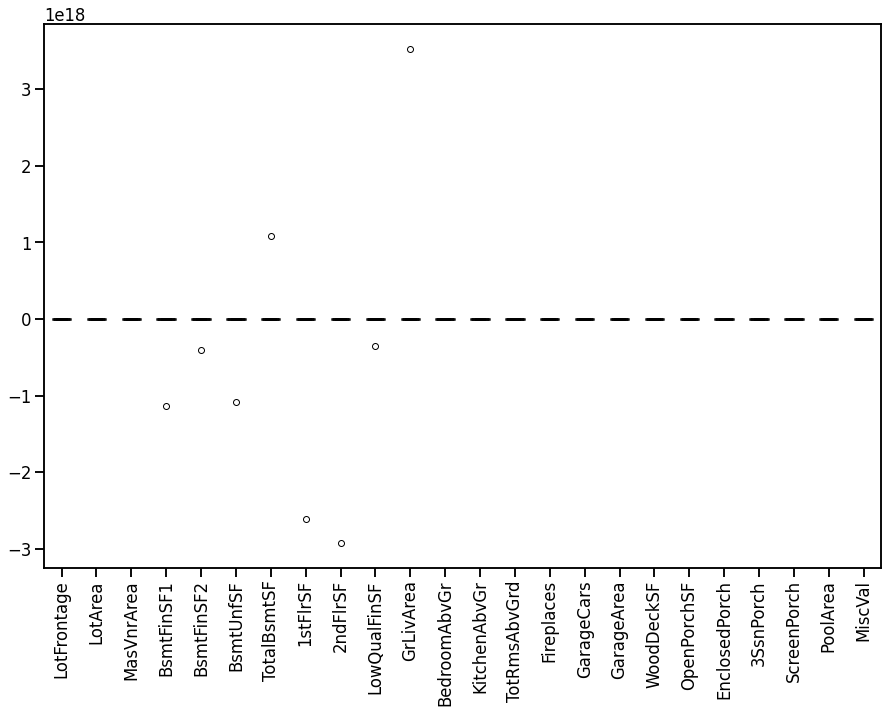

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
# Define the style of the box style
boxplot_property = {
    "vert": True,
    "whis": 100,
    "patch_artist": True,
    "widths": 0.5,
    "rot": 90,
    "boxprops": dict(linewidth=3, color="black", alpha=0.9),
    "medianprops": dict(linewidth=2.5, color="black", alpha=0.9),
    "whiskerprops": dict(linewidth=3, color="black", alpha=0.9),
    "capprops": dict(linewidth=3, color="black", alpha=0.9),
}

_, ax = plt.subplots(figsize=(15, 10))
_ = coefs.plot.box(**boxplot_property, ax=ax)

### 2-Repita o mesmo experimento com regressor ridge(**sklearn.linear_model.Ridge**) com os parâmetros padrões ? 

In [40]:
from sklearn.linear_model import Ridge

model = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='mean'),
    Ridge()
)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()), ('ridge', Ridge())])

In [41]:
display("Os steps do pipeline:")
display(model.steps)
print("Os parâmetros do pipeline acima são:")
for parameter in model.get_params():
    print(f"{parameter}")

'Os steps do pipeline:'

[('standardscaler', StandardScaler()),
 ('simpleimputer', SimpleImputer()),
 ('ridge', Ridge())]

Os parâmetros do pipeline acima são:
memory
steps
verbose
standardscaler
simpleimputer
ridge
standardscaler__copy
standardscaler__with_mean
standardscaler__with_std
simpleimputer__add_indicator
simpleimputer__copy
simpleimputer__fill_value
simpleimputer__missing_values
simpleimputer__strategy
simpleimputer__verbose
ridge__alpha
ridge__copy_X
ridge__fit_intercept
ridge__max_iter
ridge__normalize
ridge__random_state
ridge__solver
ridge__tol


In [42]:
cv_results = cross_validate(
    model,
    data_numerical,
    target,
    cv=cv, 
    scoring = "neg_mean_absolute_error",
    return_estimator=True, 
    n_jobs=-1)

In [43]:
coefs = [estimator[-1].coef_ for estimator in cv_results["estimator"]] # list compreension
coefs = pd.DataFrame(coefs, columns=numerical_features)
display(coefs.head())

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,3929.617157,1981.858009,7444.583864,10657.027572,556.301398,3232.199958,14895.816406,8137.398609,13725.453977,-1488.457016,...,2711.444176,11823.863979,4801.915081,2711.106845,2267.164011,-3534.440214,1243.361676,-149.761244,1237.909483,333.639132
1,-1375.552902,1362.517610,7221.393169,8246.324977,-422.016966,3864.862901,12186.148716,9184.541855,11839.662302,-348.028839,...,3379.739752,20127.786874,-1326.138326,5739.714241,1987.387702,-2538.363538,1052.063285,2234.386249,-2160.426744,-12.665691
2,265.236213,309.018069,6282.372588,8253.593394,-242.861925,2797.037189,11281.209617,11104.085345,13962.219997,-1879.995593,...,1628.112829,19934.392107,-1291.422301,4457.764659,2688.252610,-1911.177571,132.811570,2183.688079,-4380.854296,556.108702
3,-121.568502,1542.749110,6024.989170,7685.761121,-392.061536,3129.640149,10930.363587,9709.627043,10398.230448,-2933.498995,...,3387.595628,21721.678003,-2034.683235,5347.689786,2071.618468,-2400.859339,820.006447,2182.844535,-1406.754684,-108.395236
4,-1648.371407,2187.433111,7193.088844,8606.665507,-221.460701,2454.864306,11307.678190,10321.969713,12200.933214,-1890.307878,...,4202.531962,22112.345838,-3127.016634,5211.956093,1158.991002,-3259.704057,1390.695324,1815.564470,-2027.746132,108.869489


In [44]:
display(coefs.describe().loc[["min", "max"]])

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
min,-1648.371407,309.018069,6024.989170,7685.761121,-422.016966,2454.864306,10930.363587,8137.398609,10398.230448,-2933.498995,...,1628.112829,11823.863979,-3127.016634,2711.106845,1158.991002,-3534.440214,132.811570,-149.761244,-4380.854296,-108.395236
max,3929.617157,2187.433111,7444.583864,10657.027572,556.301398,3864.862901,14895.816406,11104.085345,13962.219997,-348.028839,...,4202.531962,22112.345838,4801.915081,5739.714241,2688.252610,-1911.177571,1390.695324,2234.386249,1237.909483,556.108702


In [45]:
all_coeficientes = []   # lista com todos os coeficientes de cada fold
# fold_ind = é o indice de cada fold interno, aqui no caso varia entre 0 e 4
for fold_ind in cv_results['estimator']:
    all_coeficientes.append(fold_ind.get_params()['ridge'].coef_)


all_coefs = np.array(all_coeficientes)
print(f"Maior coeficiente de ajuste encontrado é: {all_coefs.max():.2e}")

Maior coeficiente de ajuste encontrado é: 2.21e+04


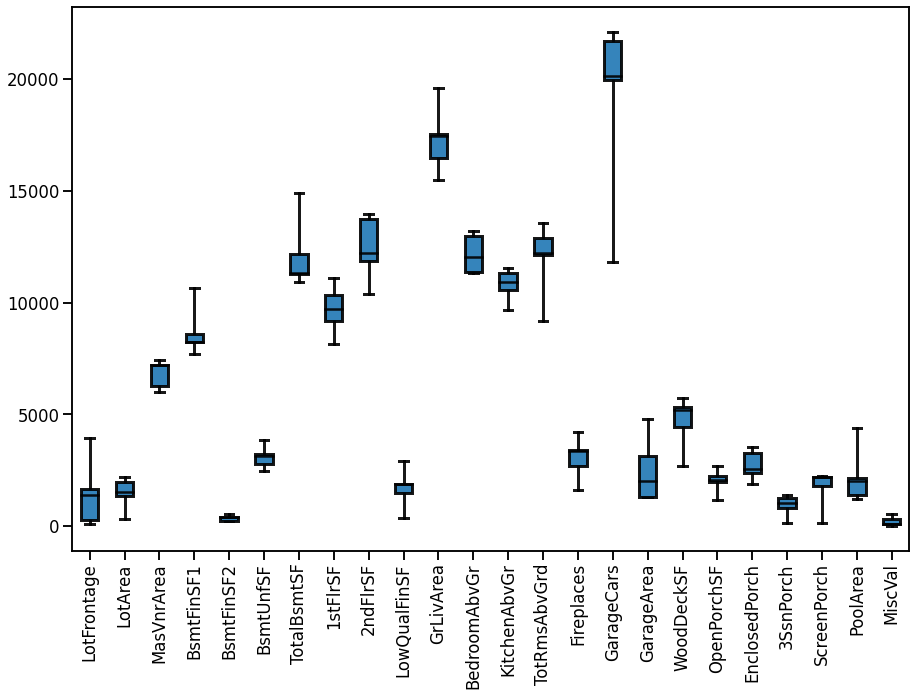

In [46]:
_, ax = plt.subplots(figsize=(15, 10))
_ = coefs.abs().plot.box(**boxplot_property, ax=ax)

A regularização reduzirá os coeficientes para zero. Evita erros numéricos. Nesse caso, o extremo é em torno de 20.000.

### 3-Quais são as duas features mais importantes usados ​​pelo regressor de ridge? Você pode fazer um gráfico de boxplot dos coeficientes em todos os folds para obter um bom insight


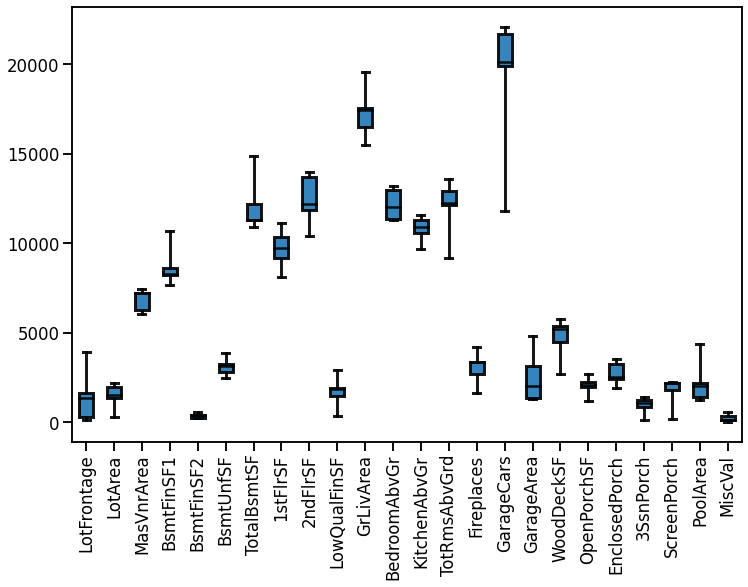

In [47]:
_, ax = plt.subplots(figsize=(12, 8))
_ = coefs.abs().plot.box(**boxplot_property, ax=ax)

Olhando a variabilidade da variável "GarageCars"

In [48]:
coefs.describe()["GarageCars"]

count        5.000000
mean     19144.013360
std       4202.155654
min      11823.863979
25%      19934.392107
50%      20127.786874
75%      21721.678003
max      22112.345838
Name: GarageCars, dtype: float64

### 4 - Remova a feature "GarageArea" do dataset e repita o último experimento com a regressão ridge. Qual é o impacto nos pesos ao remover a feature "GarageArea" do dataset?

In [49]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars","WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

data_numerical = data[numerical_features]

In [50]:
model = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='mean'),
    Ridge()
)
cv_results = cross_validate(
    model,
    data_numerical,
    target,
    cv=cv, 
    scoring = "neg_mean_absolute_error",
    return_estimator=True, 
    n_jobs=-1)

coefs = [estimator[-1].coef_ for estimator in cv_results["estimator"]] # list compreension
coefs = pd.DataFrame(coefs, columns=numerical_features)
display(coefs.head())

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,4151.749516,1997.520065,7473.917306,10828.054914,543.840781,3168.435302,15003.969331,8470.720856,13720.484903,-1405.658124,...,12070.551391,2386.239475,15776.909557,2751.389297,2393.011393,-3469.221866,1221.869913,-114.525458,1243.644875,391.087303
1,-1469.189482,1345.572727,7176.198100,8180.904492,-427.730279,3881.770976,12133.242454,9116.104926,11837.211270,-362.801521,...,12923.628581,3467.212309,19048.514208,5737.746859,1949.659499,-2566.868224,1067.305606,2227.286914,-2181.410338,-29.374872
2,197.925566,291.197814,6228.718712,8198.564701,-239.642967,2822.461465,11251.024569,10997.234830,13953.956052,-1891.962582,...,9235.808912,1724.924814,18898.341512,4443.435220,2631.911129,-1947.245089,133.025089,2184.192621,-4400.332569,541.975608
3,-274.916933,1557.853092,5976.383055,7612.933900,-409.954765,3155.254965,10873.969138,9550.438771,10397.973402,-2930.068497,...,13632.781329,3532.488688,20095.045610,5350.346076,1997.387629,-2414.848544,809.438285,2192.741021,-1432.986848,-133.931956
4,-1859.971712,2172.886058,7098.476732,8463.956827,-219.155074,2478.796159,11183.776347,10167.007212,12157.786091,-1912.257120,...,12296.423200,4381.209220,19604.605737,5204.608173,1059.143346,-3297.951937,1415.298491,1817.322730,-2047.309805,68.276493


In [51]:
display(coefs.describe().loc[["min", "max"]])

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
min,-1859.971712,291.197814,5976.383055,7612.933900,-427.730279,2478.796159,10873.969138,8470.720856,10397.973402,-2930.068497,...,9235.808912,1724.924814,15776.909557,2751.389297,1059.143346,-3469.221866,133.025089,-114.525458,-4400.332569,-133.931956
max,4151.749516,2172.886058,7473.917306,10828.054914,543.840781,3881.770976,15003.969331,10997.234830,13953.956052,-362.801521,...,13632.781329,4381.209220,20095.045610,5737.746859,2631.911129,-1947.245089,1415.298491,2227.286914,1243.644875,541.975608


In [52]:
all_coeficientes = []   # lista com todos os coeficientes de cada fold
# fold_ind = é o indice de cada fold interno, aqui no caso varia entre 0 e 4
for fold_ind in cv_results['estimator']:
    all_coeficientes.append(fold_ind.get_params()['ridge'].coef_)


all_coefs = np.array(all_coeficientes)
print(f"Maior coeficiente de ajuste encontrado é: {all_coefs.max():.2e}")

Maior coeficiente de ajuste encontrado é: 2.01e+04


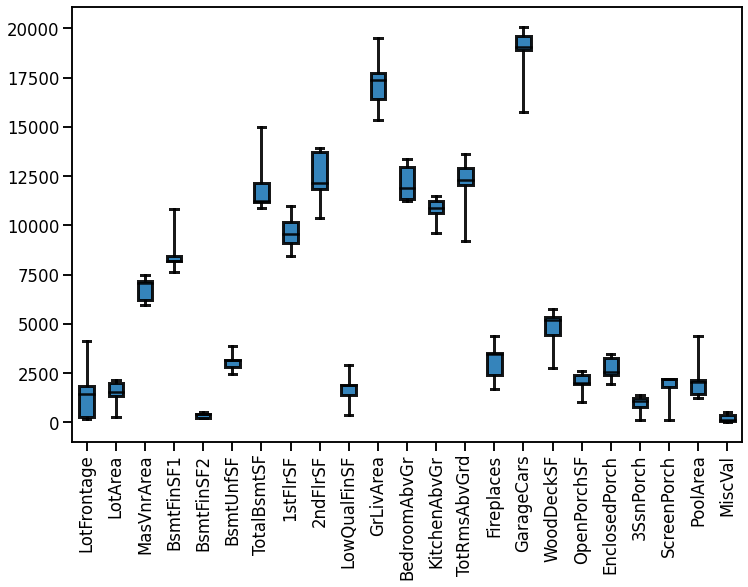

In [53]:
_, ax = plt.subplots(figsize=(12, 8))
_ = coefs.abs().plot.box(**boxplot_property, ax=ax)

Para entender melhor o que aconteceu é preciso olhar a variabilidade  do coeficiente "GarageCars" durante o experimento. Vamos checar o qto mudou a desvio padrão desta variável.

In [54]:
coefs.describe()["GarageCars"]

count        5.000000
mean     18684.683325
std       1693.262386
min      15776.909557
25%      18898.341512
50%      19048.514208
75%      19604.605737
max      20095.045610
Name: GarageCars, dtype: float64

### 5- Qual é a razão para observarmos o impacto no peso do coeficiente mais importante, após a retirada da feature "GarageCars"?

As features "GarageCars" e "GarageArea" são correlacionadas e carregam portanto informações similares.

### 6-Agora, procuraremos a força de regularização que maximizará o desempenho estatístico de nosso modelo preditivo. Ajuste um sklearn.linear_model.RidgeCV ao invés de um regressor Ridge passe alphas = np.logspace (-1, 3, num = 30) para explorar o efeito de alterar a intensidade da regularização.Existem diferenças importantes em relação aos pesos mais importantes?

In [63]:
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-1, 3, num=30)
model = make_pipeline(
    StandardScaler(),
    SimpleImputer(strategy='mean'),
    RidgeCV(alphas=alphas, store_cv_values=True)
)
model

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('simpleimputer', SimpleImputer()),
                ('ridgecv',
                 RidgeCV(alphas=array([1.00000000e-01, 1.37382380e-01, 1.88739182e-01, 2.59294380e-01,
       3.56224789e-01, 4.89390092e-01, 6.72335754e-01, 9.23670857e-01,
       1.26896100e+00, 1.74332882e+00, 2.39502662e+00, 3.29034456e+00,
       4.52035366e+00, 6.21016942e+00, 8.53167852e+00, 1.17210230e+01,
       1.61026203e+01, 2.21221629e+01, 3.03919538e+01, 4.17531894e+01,
       5.73615251e+01, 7.88046282e+01, 1.08263673e+02, 1.48735211e+02,
       2.04335972e+02, 2.80721620e+02, 3.85662042e+02, 5.29831691e+02,
       7.27895384e+02, 1.00000000e+03]),
                         store_cv_values=True))])

In [64]:
display("Os steps do pipeline:")
display(model.steps)
print("Os parâmetros do pipeline acima são:")
for parameter in model.get_params():
    print(f"{parameter}")

'Os steps do pipeline:'

[('standardscaler', StandardScaler()),
 ('simpleimputer', SimpleImputer()),
 ('ridgecv',
  RidgeCV(alphas=array([1.00000000e-01, 1.37382380e-01, 1.88739182e-01, 2.59294380e-01,
         3.56224789e-01, 4.89390092e-01, 6.72335754e-01, 9.23670857e-01,
         1.26896100e+00, 1.74332882e+00, 2.39502662e+00, 3.29034456e+00,
         4.52035366e+00, 6.21016942e+00, 8.53167852e+00, 1.17210230e+01,
         1.61026203e+01, 2.21221629e+01, 3.03919538e+01, 4.17531894e+01,
         5.73615251e+01, 7.88046282e+01, 1.08263673e+02, 1.48735211e+02,
         2.04335972e+02, 2.80721620e+02, 3.85662042e+02, 5.29831691e+02,
         7.27895384e+02, 1.00000000e+03]),
          store_cv_values=True))]

Os parâmetros do pipeline acima são:
memory
steps
verbose
standardscaler
simpleimputer
ridgecv
standardscaler__copy
standardscaler__with_mean
standardscaler__with_std
simpleimputer__add_indicator
simpleimputer__copy
simpleimputer__fill_value
simpleimputer__missing_values
simpleimputer__strategy
simpleimputer__verbose
ridgecv__alpha_per_target
ridgecv__alphas
ridgecv__cv
ridgecv__fit_intercept
ridgecv__gcv_mode
ridgecv__normalize
ridgecv__scoring
ridgecv__store_cv_values


In [65]:
numerical_features = [
    "LotFrontage", "LotArea", "MasVnrArea", "BsmtFinSF1", "BsmtFinSF2",
    "BsmtUnfSF", "TotalBsmtSF", "1stFlrSF", "2ndFlrSF", "LowQualFinSF",
    "GrLivArea", "BedroomAbvGr", "KitchenAbvGr", "TotRmsAbvGrd", "Fireplaces",
    "GarageCars", "GarageArea", "WoodDeckSF", "OpenPorchSF", "EnclosedPorch",
    "3SsnPorch", "ScreenPorch", "PoolArea", "MiscVal",
]

data_numerical = data[numerical_features]

In [67]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results = cross_validate(
    model,
    data_numerical,
    target,
    cv=cv, 
    scoring = "neg_mean_absolute_error",
    return_estimator=True, 
    return_train_score=True,
    n_jobs=-1)

coefs = [estimator[-1].coef_ for estimator in cv_results["estimator"]] # list compreension
coefs = pd.DataFrame(coefs, columns=numerical_features)
display(coefs.head())

,LotFrontage,LotArea,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,...,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
0,61.892403,1477.309879,6155.310482,6942.575642,-545.421991,2989.657390,9980.819892,8503.830522,8877.919458,-1264.418995,...,5136.322416,12984.065764,6778.192445,5166.193092,2957.298841,-2452.950419,955.604036,1821.482925,-1184.164427,5.331057
1,601.947572,1694.842370,7280.067381,7233.601141,-284.981048,2462.965716,9866.770147,8609.385991,9082.060726,-1357.930108,...,5327.718897,12596.444027,6174.364683,4835.826944,3116.951672,-2394.883215,1331.948862,1372.290683,-743.576649,-63.877404
2,729.296327,1759.128883,7802.118451,6641.320616,-370.042554,3122.807571,9979.441786,7959.486370,8326.819490,-1096.164674,...,5055.603286,12342.540207,7437.090656,5473.420560,3067.481059,-2327.381879,1054.052743,1742.710070,-3637.852969,66.685071
3,688.291181,2074.252987,7570.729653,6434.310820,-330.343822,3298.508345,9876.016300,8134.284728,9128.869688,-1258.666965,...,5516.486437,12476.432263,6929.023257,5160.136607,2976.742912,-2841.322773,596.599083,1349.599791,-997.284981,-19.312440
4,3567.129986,2167.213310,6214.872750,10991.542192,-516.526228,3132.640349,14702.593447,8078.092620,12925.265972,-2263.860850,...,2953.135325,10945.002814,5859.586872,3431.155815,2966.883532,-3082.555472,877.284425,1200.071411,2284.019887,-418.875687


In [68]:
all_coeficientes = []   # lista com todos os coeficientes de cada fold
# fold_ind = é o indice de cada fold interno, aqui no caso varia entre 0 e 4
for fold_ind in cv_results['estimator']:
    all_coeficientes.append(fold_ind.get_params()['ridgecv'].coef_)


all_coefs = np.array(all_coeficientes)
print(f"Maior coeficiente de ajuste encontrado é: {all_coefs.max():.2e}")

Maior coeficiente de ajuste encontrado é: 1.67e+04


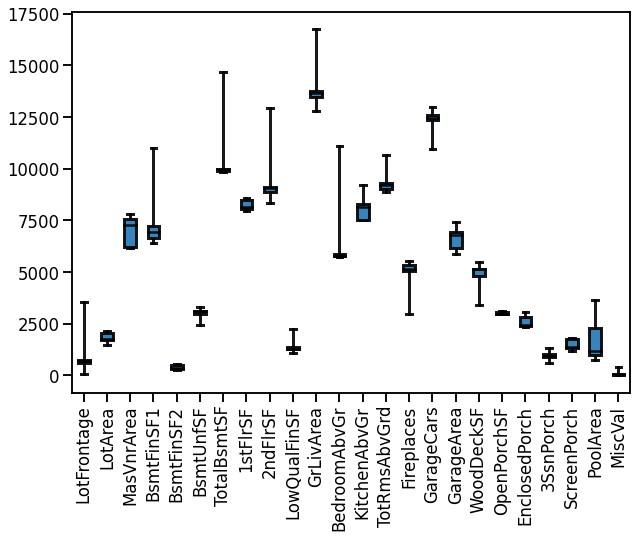

In [69]:
coefs = [estimator[-1].coef_ for estimator in cv_results["estimator"]]
coefs = pd.DataFrame(coefs, columns=data_numerical.columns)
_, ax = plt.subplots(figsize=(10, 7))
_ = coefs.abs().plot.box(**boxplot_property, ax=ax)

No gráfico, vemos que as classificações e a magnitude das características não mudaram muito. A magnitude diminuiu ligeiramente; isso pode significar que nosso modelo escolheu um parâmetro de regularização mais forte do que o valor padrão em Ridge.

In [70]:
mse_alphas = [est[-1].cv_values_.mean(axis=0)
              for est in cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas

,0.100000,0.137382,0.188739,0.259294,0.356225,0.489390,0.672336,0.923671,1.268961,1.743329,...,57.361525,78.804628,108.263673,148.735211,204.335972,280.721620,385.662042,529.831691,727.895384,1000.000000
0,2.017945e+09,2.017922e+09,2.017891e+09,2.017849e+09,2.017791e+09,2.017711e+09,2.017602e+09,2.017452e+09,2.017247e+09,2.016967e+09,...,1.992414e+09,1.985844e+09,1.978479e+09,1.970753e+09,1.963485e+09,1.958036e+09,1.956485e+09,1.961839e+09,1.978307e+09,2.011672e+09
1,2.052119e+09,2.052096e+09,2.052064e+09,2.052021e+09,2.051961e+09,2.051879e+09,2.051767e+09,2.051613e+09,2.051402e+09,2.051114e+09,...,2.025714e+09,2.018889e+09,2.011228e+09,2.003169e+09,1.995532e+09,1.989662e+09,1.987596e+09,1.992262e+09,2.007764e+09,2.039779e+09
2,1.975546e+09,1.975522e+09,1.975489e+09,1.975443e+09,1.975381e+09,1.975295e+09,1.975178e+09,1.975017e+09,1.974797e+09,1.974495e+09,...,1.946957e+09,1.939265e+09,1.930490e+09,1.921082e+09,1.911926e+09,1.904501e+09,1.901049e+09,1.904743e+09,1.919927e+09,1.952433e+09
3,2.061163e+09,2.061139e+09,2.061107e+09,2.061062e+09,2.061001e+09,2.060916e+09,2.060801e+09,2.060642e+09,2.060425e+09,2.060129e+09,...,2.033240e+09,2.025755e+09,2.017193e+09,2.007943e+09,1.998795e+09,1.991093e+09,1.986919e+09,1.989306e+09,2.002524e+09,2.032465e+09
4,1.447502e+09,1.447494e+09,1.447484e+09,1.447469e+09,1.447450e+09,1.447423e+09,1.447386e+09,1.447336e+09,1.447267e+09,1.447174e+09,...,1.440949e+09,1.440399e+09,1.440773e+09,1.442890e+09,1.447920e+09,1.457427e+09,1.473432e+09,1.498574e+09,1.536470e+09,1.592317e+09


In [71]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
25736.615 +/- 541.853


In [72]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the test set:
27207.167 +/- 1995.130


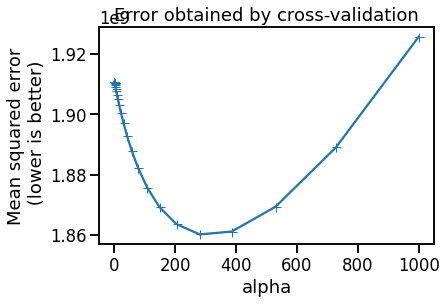

In [73]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Mean squared error\n (lower is better)")
plt.xlabel("alpha")
_ = plt.title("Error obtained by cross-validation")

In [75]:
alpha = [estimator[-1].alpha_ for estimator in cv_results["estimator"]]
alpha = pd.Series(alpha, name="alpha")
alpha

0    385.662042
1    385.662042
2    385.662042
3    385.662042
4     78.804628
Name: alpha, dtype: float64

In [ ]:
sns.set(style='whitegrid')
ax = sns.swarmplot(x=alpha)